In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
#import shap
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neural_network import MLPClassifier
import catboost
from catboost import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load and process data function
def dataloader(filepath):
    raw_data = pd.read_csv(filepath)
    med_columns = raw_data.columns[raw_data.columns.str.contains('Med_')]
    raw_data[med_columns] = raw_data[med_columns].fillna(0)
    columns_to_rename = raw_data.columns[65:273]
    new_column_names = [col.rsplit('_', 1)[0] for col in columns_to_rename]
    raw_data.rename(columns=dict(zip(columns_to_rename, new_column_names)), inplace=True)
    filtered_df = raw_data[raw_data['Is transferred to ICU'] == 1].drop('Is transferred to ICU', axis=1, errors='ignore')
    transform_dtypes_data = filtered_df.copy().iloc[:, 2:]
    category_columns_1 = transform_dtypes_data.columns[
        transform_dtypes_data.columns.str.contains('Med_') | transform_dtypes_data.columns.str.startswith('Diagnosis_')
    ]
    transform_dtypes_data[category_columns_1] = transform_dtypes_data[category_columns_1].applymap(lambda x: 0 if x == 0.0 else 1)
    category_columns_2 = ['Gender', 'Insurance', 'Race', 'triage_Acuity', 'Arrival transport']
    transform_dtypes_data[category_columns_1] = transform_dtypes_data[category_columns_1].astype('category')
    transform_dtypes_data[category_columns_2] = transform_dtypes_data[category_columns_2].astype('category')
    # print(transform_dtypes_data.dtypes)

    def remove_outliers(df):
        for column in df.columns:
            if pd.api.types.is_numeric_dtype(df[column]):
                lower_bound = df[column].quantile(0.01)
                upper_bound = df[column].quantile(0.99)
                df[column] = df[column].apply(lambda v: lower_bound if v < lower_bound else upper_bound if v > upper_bound else v)
            if column == 'Age':
                df[column] = df[column].apply(lambda v: 91 if v > 91 else v)
        return df
    
    data = remove_outliers(transform_dtypes_data)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1].squeeze()  # Ensure y is a 1D Series
    return X, y

# Feature selection function
def select_features(X, selected_features):
    print(f'Selected feature count: {len(selected_features)}')
    return X[selected_features]


def fillna_mean(X):
    for column in list(X.columns[X.isnull().sum()>0]):
        mean_val = X[column].mean()
        X[column].fillna(mean_val,inplace=True)
    return X


In [3]:
cd = '/Users/hnwang/bmc/ihm_icu/' 
search_path = cd + '/fs_corr_step1/'
save_path = cd +'/fs_imp_step2-1/ML_models_compare/'

raw_data_path = '/Users/hnwang/ihm/without_fillna/alldata.csv'
X, y = dataloader(raw_data_path)

fs1 = pd.read_excel('/Users/hnwang/bmc/ihm_icu/fs_corr_step1' + '/significantPvalue_ihm.xlsx') #encoding_errors='ignore',,encoding="utf-8"
selected_features=fs1['ID'].tolist()
X_fs1 = select_features(X, selected_features)

Selected feature count: 168


In [21]:
def model_10cv_LR(X,y):
    #from sklearn.linear_model import LogisticRegression
    #from sklearn.model_selection import StratifiedKFold
    #from sklearn import metrics
    X = fillna_mean(X)
    skf = StratifiedKFold(n_splits=10)
    model = LogisticRegression(max_iter=500)
    ## note X,y is dataFrame, not array, so .split(X,y) is not right
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        probs = model.predict_proba(X_test)
        y_tepred = probs[:,1]
        auc_te = metrics.roc_auc_score(y_test, y_tepred)        
        print('auc_te = ', auc_te)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====Logistic Regression model: meanAUC={}'.format(meanAUC))
    print('====Logistic Regression model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5))) 
    # print('====Logistic Regression model: meanAUC={}'.format(meanAUC),file=log)
    # print('====Logistic Regression model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY}) 
    if os.path.exists(save_path+'/LR/')==False:
        os.makedirs(save_path+'/LR/')
    predict_result.to_csv(save_path+'/LR/predict_result_LR.csv',index=False)    
    return predict_result  

predict_result = model_10cv_LR(X_fs1, y)

auc_te =  0.7725244932795893
auc_te =  0.7609568277557032
auc_te =  0.7664412185197403
auc_te =  0.7754352368520456
auc_te =  0.7589629385241394
auc_te =  0.78235886180961
auc_te =  0.7775307331487671
auc_te =  0.7813235198894909
auc_te =  0.7697630089185562
auc_te =  0.7729965535962422
====Logistic Regression model: meanAUC=0.7718293392293883
====Logistic Regression model: 95% CI=[0.7594115636012413, 0.7821259098775832]


In [ ]:
def model_10cv_SVM(X,y):
    #from sklearn.svm import LinearSVC
    #from sklearn.model_selection import StratifiedKFold
    #from sklearn import metrics
    X = fillna_mean(X)
    skf = StratifiedKFold(n_splits=10)
    '''
    model = LinearSVC(penalty='l2', loss='squared_hinge', 
                dual=False, tol=0.0001, C=2.0, multi_class='ovr', 
                fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
                verbose=0, random_state=0, max_iter=100)
    '''
    # model = LinearSVC(max_iter=500)
    model = SVC(probability=True)
    ## note X,y is dataFrame, not array, so .split(X,y) is not right
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        '''
        since 'LinearSVC' object has no attribute 'predict_proba'
        we use its decision function (predict confidence scores for samples)
        '''
        # prob_pos = model.decision_function(X_test)
        # y_tepred = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        probs = model.predict_proba(X_test)
        y_tepred = probs[:,1]
        auc_te = metrics.roc_auc_score(y_test, y_tepred)        
        print('auc_te = ', auc_te)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====SVM model: meanAUC={}'.format(meanAUC))
    print('====SVM model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5))) 
    # print('====SVM model: meanAUC={}'.format(meanAUC),file=log)
    # print('====SVM model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY}) 
    if os.path.exists(save_path+'/SVM/')==False:
        os.makedirs(save_path+'/SVM/')
    predict_result.to_csv(save_path+'/SVM/predict_result_SVM.csv',index=False)    
    return predict_result    

predict_result = model_10cv_SVM(X_fs1, y)

auc_te =  0.6837653426668387
auc_te =  0.6452981031754
auc_te =  0.6687179340056134
auc_te =  0.6634475157670258


In [24]:
def model_10cv_DTC(X,y):
    #from sklearn.tree import DecisionTreeClassifier
    #from sklearn.model_selection import StratifiedKFold
    #from sklearn import metrics
    #import graphviz
    X = fillna_mean(X)
    skf = StratifiedKFold(n_splits=10)
    model = DecisionTreeClassifier(min_samples_split=20, min_samples_leaf=50)
    ## note X,y is dataFrame, not array, so .split(X,y) is not right
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        probs = model.predict_proba(X_test)
        y_tepred = probs[:,1]
        auc_te = metrics.roc_auc_score(y_test, y_tepred)        
        print('auc_te = ', auc_te)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====Decision Tree Classifier model: meanAUC={}'.format(meanAUC))
    print('====Decision Tree Classifier model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5))) 
    # print('====Decision Tree Classifier model: meanAUC={}'.format(meanAUC),file=log)
    # print('====Decision Tree Classifier model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY}) 
    if os.path.exists(save_path+'/DTC/')==False:
        os.makedirs(save_path+'/DTC/')
    predict_result.to_csv(save_path+'/DTC/predict_result_DTC.csv',index=False)    
    return predict_result  

predict_result = model_10cv_DTC(X_fs1, y)

auc_te =  0.7091922118782246
auc_te =  0.7074714663453492
auc_te =  0.6720129913598134
auc_te =  0.7082950812617446
auc_te =  0.675406667336078
auc_te =  0.7190259827196266
auc_te =  0.7040377452316402
auc_te =  0.7089151971682028
auc_te =  0.7311625693286807
auc_te =  0.6859300148044687
====Decision Tree Classifier model: meanAUC=0.7021449927433829
====Decision Tree Classifier model: 95% CI=[0.672776568454473, 0.7284318373416435]


In [25]:
def model_10cv_KNN(X,y):
    #from sklearn.neighbors import KNeighborsClassifier
    #from sklearn.model_selection import StratifiedKFold
    #from sklearn import metrics
    X = fillna_mean(X)
    skf = StratifiedKFold(n_splits=10)
    model = KNeighborsClassifier(60)
    ## note X,y is dataFrame, not array, so .split(X,y) is not right
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        probs = model.predict_proba(X_test)
        y_tepred = probs[:,1]
        auc_te = metrics.roc_auc_score(y_test, y_tepred)        
        print('auc_te = ', auc_te)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====KNN Classifier model: meanAUC={}'.format(meanAUC))
    print('====KNN Classifier model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5))) 
    # print('====KNN Classifier model: meanAUC={}'.format(meanAUC),file=log)
    # print('====KNN Classifier model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY}) 
    if os.path.exists(save_path+'/KNN/')==False:
        os.makedirs(save_path+'/KNN/')
    predict_result.to_csv(save_path+'/KNN/predict_result_KNN.csv',index=False)    
    return predict_result  

predict_result = model_10cv_KNN(X_fs1, y)

auc_te =  0.6926481909160894
auc_te =  0.6737170016113686
auc_te =  0.6606061040743237
auc_te =  0.6994630365450729
auc_te =  0.6542939145735611
auc_te =  0.6843468936927115
auc_te =  0.6960825097184169
auc_te =  0.6847209331884817
auc_te =  0.6823718002377325
auc_te =  0.6979045338984065
====KNN Classifier model: meanAUC=0.6826154918456165
====KNN Classifier model: 95% CI=[0.6557141572112327, 0.699112373449573]


In [26]:
def model_10cv_NB(X,y):
    #from sklearn.naive_bayes import GaussianNB
    #from sklearn.model_selection import StratifiedKFold
    #from sklearn import metrics
    X = fillna_mean(X)
    skf = StratifiedKFold(n_splits=10)
    model = GaussianNB(var_smoothing=1e-8)
    ## note X,y is dataFrame, not array, so .split(X,y) is not right
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        probs = model.predict_proba(X_test)
        y_tepred = probs[:,1]
        auc_te = metrics.roc_auc_score(y_test, y_tepred)        
        print('auc_te = ', auc_te)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====Naive Bayes model: meanAUC={}'.format(meanAUC))
    print('====Naive Bayes model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5))) 
    # print('====Naive Bayes model: meanAUC={}'.format(meanAUC),file=log)
    # print('====Naive Bayes model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY}) 
    if os.path.exists(save_path+'/NB/')==False:
        os.makedirs(save_path+'/NB/')
    predict_result.to_csv(save_path+'/NB/predict_result_NB.csv',index=False)    
    return predict_result  

predict_result = model_10cv_NB(X_fs1, y)

auc_te =  0.7129821554086039
auc_te =  0.6997624785429786
auc_te =  0.6929577936205108
auc_te =  0.725258679634119
auc_te =  0.6842936994056584
auc_te =  0.7075653034584654
auc_te =  0.7166764687600111
auc_te =  0.7052579386491885
auc_te =  0.7219103743688966
auc_te =  0.6918195146334638
====Naive Bayes model: meanAUC=0.7058484406481895
====Naive Bayes model: 95% CI=[0.6859870078319147, 0.724505310949444]


In [27]:
def model_10cv_MLP(X,y):
    #from sklearn.neural_network import MLPClassifier
    #from sklearn.model_selection import StratifiedKFold
    #from sklearn import metrics
    X = fillna_mean(X)
    skf = StratifiedKFold(n_splits=10)
    #model = MLPClassifier(solver='adam',alpha=1e-5,activation='logisic', hidden_layer_sizes=(10,2),max_iter=2000,tol=1e-4) #solver{｡ｮlbfgs｡ｯ, ｡ｮsgd｡ｯ, ｡ｮadam｡ｯ}
    model = MLPClassifier(max_iter=500)
    ## note X,y is dataFrame, not array, so .split(X,y) is not right
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        probs = model.predict_proba(X_test)
        y_tepred = probs[:,1]
        auc_te = metrics.roc_auc_score(y_test, y_tepred)        
        print('auc_te = ', auc_te)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====neural network MLP Classifier model: meanAUC={}'.format(meanAUC))
    print('====neural network MLP Classifier model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5))) 
    # print('====neural network MLP Classifier model: meanAUC={}'.format(meanAUC),file=log)
    # print('====neural network MLP Classifier model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY}) 
    if os.path.exists(save_path+'/MLP/')==False:
        os.makedirs(save_path+'/MLP/')
    predict_result.to_csv(save_path+'/MLP/predict_result_MLP.csv',index=False)    
    return predict_result  

predict_result = model_10cv_MLP(X_fs1, y)


auc_te =  0.7847615700562786
auc_te =  0.735333916677425
auc_te =  0.7397233418922343
auc_te =  0.7296475071603097
auc_te =  0.7412833091867133
auc_te =  0.7719423445650979
auc_te =  0.7846025848837377
auc_te =  0.7639341549574439
auc_te =  0.7756094585965173
auc_te =  0.7580294510866575
====neural network MLP Classifier model: meanAUC=0.7584867639062415
====neural network MLP Classifier model: 95% CI=[0.7309269493016606, 0.7847257983924568]


In [28]:
def model_10cv_RF(X,y):
    #from sklearn.ensemble import RandomForestClassifier
    #from sklearn.model_selection import StratifiedKFold
    #from sklearn import metrics
    skf = StratifiedKFold(n_splits=10)
    model = RandomForestClassifier(n_estimators=500)
    ## note X,y is dataFrame, not array, so .split(X,y) is not right
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        probs = model.predict_proba(X_test)
        y_tepred = probs[:,1]
        auc_te = metrics.roc_auc_score(y_test, y_tepred)        
        print('auc_te = ', auc_te)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====Random Forest model: meanAUC={}'.format(meanAUC))
    print('====Random Forest model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5))) 
    # print('====Random Forest model: meanAUC={}'.format(meanAUC),file=log)
    # print('====Random Forest model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY}) 
    if os.path.exists(save_path+'/RF/')==False:
        os.makedirs(save_path+'/RF/')
    predict_result.to_csv(save_path+'/RF/predict_result_RF.csv',index=False)      
    return predict_result    

predict_result = model_10cv_RF(X_fs1, y)

auc_te =  0.7911753666221986
auc_te =  0.7651514064808572
auc_te =  0.764876469716313
auc_te =  0.7803583980032419
auc_te =  0.7459452804115924
auc_te =  0.7842362017605516
auc_te =  0.7712884732163776
auc_te =  0.7832330884768777
auc_te =  0.7820711666830097
auc_te =  0.7785566001860722
====Random Forest model: meanAUC=0.7746892451557092
====Random Forest model: 95% CI=[0.7502047980051545, 0.789614054528328]


In [67]:
def model_10cv_XGBoost(X,y):
    #import xgboost
    #from sklearn.model_selection import StratifiedKFold
    #from sklearn import metrics
    skf = StratifiedKFold(n_splits=10)#, random_state=0
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        D_train = xgboost.DMatrix(X_train,label=y_train, enable_categorical=True)
        D_test = xgboost.DMatrix(X_test,label=y_test, enable_categorical=True)
        ###
        params = {
            "eta": 0.01,
            "booster": "gbtree",
            "objective": "binary:logistic",
            "eval_metric":"auc",
            "min_child_weight": 150,
        }
        steps = 1000 
        model = xgboost.train(params, D_train, steps, verbose_eval=False)#
        y_tepred = model.predict(D_test)
        auc_te = metrics.roc_auc_score(y_test, y_tepred)        
        print('auc_te = ', auc_te)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====XGBoost model: meanAUC={}'.format(meanAUC))
    print('====XGBoost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5))) 
    # print('====XGBoost model: meanAUC={}'.format(meanAUC),file=log)
    # print('====XGBoost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY}) 
    if os.path.exists(save_path+'/XGBoost/')==False:
        os.makedirs(save_path+'/XGBoost/')
    predict_result.to_csv(save_path+'/XGBoost/predict_result_XGBoost.csv',index=False)    
    return predict_result    


predict_result = model_10cv_XGBoost(X_fs1, y)


auc_te =  0.8072824772041561
auc_te =  0.7799681073353129
auc_te =  0.7855092785181147
auc_te =  0.8038350092522198
auc_te =  0.7762624379001526
auc_te =  0.8116025705392109
auc_te =  0.8023252478017013
auc_te =  0.8026207554816909
auc_te =  0.7986891229010062
auc_te =  0.7951805355917123
====XGBoost model: meanAUC=0.7963275542525279
====XGBoost model: 95% CI=[0.7770962135230637, 0.8106305495388236]


In [68]:
def model_10cv_LightGBM(X,y):
    #import lightgbm as lgb
    #from sklearn.model_selection import StratifiedKFold
    #from sklearn import metrics
    skf = StratifiedKFold(n_splits=10)#, random_state=0
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        d_train = lgb.Dataset(X_train,label=y_train)
        d_test = lgb.Dataset(X_test,label=y_test)
        ###
        params = {
            "learning_rate": 0.01,
            "boosting_type": "gbdt",
            "objective": "binary",
            "metric": ['auc', 'binary_logloss'],
            'max_depth': 5,
            'verbosity': -1,
        }
        model = lgb.train(params, d_train, 1000)
        y_tepred = model.predict(X_test)
        auc_te = metrics.roc_auc_score(y_test, y_tepred)        
        print('auc_te = ', auc_te)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====LightGBM model: meanAUC={}'.format(meanAUC))
    print('====LightGBM model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5))) 
    # print('====LightGBM model: meanAUC={}'.format(meanAUC),file=log)
    # print('====LightGBM model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY}) 
    if os.path.exists(save_path+'/LightGBM/')==False:
        os.makedirs(save_path+'/LightGBM/')
    predict_result.to_csv(save_path+'/LightGBM/predict_result_LightGBM.csv',index=False)    
    return predict_result    

predict_result = model_10cv_LightGBM(X_fs1, y)  


auc_te =  0.8086631379130628
auc_te =  0.7899734148102457
auc_te =  0.788855737093512
auc_te =  0.8077008592371581
auc_te =  0.7791122172335144
auc_te =  0.821256437106422
auc_te =  0.8048881365981476
auc_te =  0.8042803114785155
auc_te =  0.8017540544871411
auc_te =  0.7940564483147061
====LightGBM model: meanAUC=0.8000540754272425
====LightGBM model: 95% CI=[0.7813045092020139, 0.8184229447879162]


In [69]:
def model_10cv_Catboost(X,y):
    #import catboost
    #from catboost import *
    #from sklearn import metrics
    skf = StratifiedKFold(n_splits=10)
    cat_features = X.select_dtypes(['category']).columns.tolist()
    model = CatBoostClassifier(iterations=1000, learning_rate=0.01, cat_features=cat_features, verbose=0)
    ## note X,y is dataFrame, not array, so .split(X,y) is not right
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        probs = model.predict_proba(X_test)
        y_tepred = probs[:,1]
        auc_te = metrics.roc_auc_score(y_test, y_tepred)        
        print('auc_te = ', auc_te)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====Catboost model: meanAUC={}'.format(meanAUC))
    print('====Catboost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5))) 
    # print('====Catboost model: meanAUC={}'.format(meanAUC),file=log)
    # print('====Catboost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY}) 
    if os.path.exists(save_path+'/Catboost/')==False:
        os.makedirs(save_path+'/Catboost/')
    predict_result.to_csv(save_path+'/Catboost/predict_result_Catboost.csv',index=False)      
    return predict_result    

predict_result = model_10cv_Catboost(X_fs1, y)

auc_te =  0.8057081653828316
auc_te =  0.7870602804833149
auc_te =  0.787954422656702
auc_te =  0.8095859691401412
auc_te =  0.776427399958879
auc_te =  0.8103701366077107
auc_te =  0.8057727157536374
auc_te =  0.8048187078965606
auc_te =  0.8030240339426525
auc_te =  0.7942525656694178
====Catboost model: meanAUC=0.7984974397491849
====Catboost model: 95% CI=[0.7788197980768771, 0.8101936989275076]


### 绘制结果图

In [70]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import itertools
#import plot_roc_pr_calibration_curves # this is myself function
from joblib import Parallel, delayed
#from function_Delong_test import DelongTest

cd = '/Users/hnwang/bmc/ihm_icu/fs_imp_step2-1' 
search_path = cd + '/ML_models_compare/'
save_path = cd + '/prediction_figure/'


In [71]:
## evaluation
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn import metrics, utils
from joblib import Parallel, delayed
from tqdm import tqdm
import scipy
import scipy.special
import itertools
import yaml
import pickle

##############
#models = ['LR', 'RF', 'CNN_V3', 'RNN_V2', ]
#colors = ['#2ca02c', '#d62728', '#1f77b4', '#ff7f0e']
fig_size = 3
q=10
scipy.interp = np.interp
#################### function only the curve #################

def get_roc_curve(y_true,y_pred):
    roc_curve = metrics.roc_curve(y_true, y_pred)
    auc = metrics.roc_auc_score(y_true, y_pred)
    return roc_curve, auc


def get_pr_curve(y_true,y_pred):
    pr_curve = metrics.precision_recall_curve(y_true, y_pred)
    return pr_curve


def get_calibration_curve(y_true,y_pred,q):
    def get_calibration_plot(y_true, y_prob, q):
        try:
            out, bins = pd.qcut(y_prob.to_numpy(), q=q, labels=False, retbins=True)
            #bins = np.percentile(y_prob.to_numpy(), [0, 20, 40, 60, 80, 100])
            P_true, P_pred = [], []
            for bin_idx in range(q):
                m = (out == bin_idx)
                P_true.append(np.mean(y_true[m]))
                P_pred.append(np.mean(y_prob[m]))
        except:
            print(q)
            print(out)
            raise
        return P_true, P_pred

    p_true, p_pred = get_calibration_plot(y_true, y_pred, q)
    brier_score = np.mean(np.square(np.array(p_true) - np.array(p_pred)))
    print('brier_score = %.3f'%brier_score) 
    cali_curve = [p_true, p_pred]      
    return cali_curve, brier_score 

################ function  the curve and 95%CI ###################
#======= ROC curves
def get_roc_CI_curve(y_true,y_pred):

    def get_roc_curve(y_true,y_pred):
        roc_curve = metrics.roc_curve(y_true, y_pred)
        auc = metrics.roc_auc_score(y_true, y_pred)
        return roc_curve, auc
    
    def bootstrap_func(i,y_true, y_pred):
        y_true_i, y_pred_i = utils.resample(y_true,y_pred,replace=True, random_state=i)
        roc_curve_i = metrics.roc_curve(y_true_i,y_pred_i)
        auc_i = metrics.roc_auc_score(y_true_i, y_pred_i)
        return roc_curve_i, auc_i
    
    def get_roc_CI(y_true, y_pred):
        roc_curves, auc_scores = zip(*Parallel(n_jobs=-1)(delayed(bootstrap_func)(i,y_true,y_pred) for i in range(1000)))
        #roc_curves, auc_scores = [], []
        #for i in range(1000):
        #    roc_curve_i, auc_i = bootstrap_func(i,y_true,y_pred)
        #    roc_curves.append(roc_curve_i)
        #    auc_scores.append(auc_i)
        print('Test AUC: {:.3f}'.format(metrics.roc_auc_score(y_true,y_pred)))
        print('Test AUC:({:.3f},{:.3f}) percentile 95% CI'.format(np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)))
        #print('Test AUC: {.3f} ({:.3f},{:.3f}) percentile'.format(np.median(auc_scores), np.percentile(auc_scores,2.5),np.percentile(auc_scores,97.5)))
        #print('Test AUC: {.3f} ({:.3f},{:.3f}) empirical'.format(np.mean(auc_scores),np.mean(auc_scores)-1.96 * np.std(auc_scores),np.mean(auc_scores)+1.96 * np.std(auc_scores)))
        
        uci = np.percentile(auc_scores, 97.5)
        dci = np.percentile(auc_scores, 2.5)
        
        tprs = []
        mean_fpr = np.linspace(0,1,100)
        for fpr, tpr,_ in roc_curves:
            tprs.append(scipy.interp(mean_fpr,fpr, tpr)) # np.interp ?
            tprs[-1][0] = 0.0 #?｣ｿ
        
        mean_tpr = np.mean(tprs, axis=0)
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr+1.96*std_tpr,1)
        tprs_lower = np.maximum(mean_tpr-1.96*std_tpr,0)
        return uci,dci,auc_scores, mean_fpr, tprs_lower, tprs_upper
    
        
    roc_curve, auc = get_roc_curve(y_true,y_pred)
    uci,dci,auc_scores, mean_fpr, tprs_lower, tprs_upper = get_roc_CI(y_true, y_pred)
   
    ## save
    '''
    result_roc_CI = {'roc_curve':roc_curve,'auc':auc,'dci':dci,'uci':uci,'auc_scores':auc_scores,
              'mean_fpr':mean_fpr,'tprs_lower':tprs_lower,'tprs_upper':tprs_upper}
    f = open(save_path+'/result_roc_CI.pkl','rb')
    pickle.dump(result_roc_CI, f)
    f.close()
    '''  
    return roc_curve, auc, uci,dci, auc_scores, mean_fpr, tprs_lower, tprs_upper



    
def plot_roc_CI(y_true,y_pred_1,ypred_2):
    fig, ax = plt.subplots(figsize=(fig_size,fig_size))
    #fpr,tpr,thresholds = metrics.roc_curve(y_true,y_score)
    # for model_1
    roc_curve, auc_1, uci,dci, auc_scores_1, mean_fpr, tprs_lower, tprs_upper = get_roc_CI_curve(y_true,y_pred_1)
    fpr = roc_curve[0];tpr = roc_curve[1]
    plt.plot(fpr,tpr,lw=1.25, label='model_1', color='green')
    plt.fill_between(mean_fpr,tprs_lower,tprs_upper, alpha=0.1, color='green')

    # for model_2
    roc_curve, auc_2, uci,dci,auc_scores_2, mean_fpr, tprs_lower, tprs_upper = get_roc_CI_curve(y_true,y_pred_2)
    fpr = roc_curve[0], tpr = roc_curve[1]
    plt.plot(fpr,tpr,lw=1.25, label='model_2', color='blue')
    plt.fill_between(mean_fpr,tprs_lower,tprs_upper, alpha=0.1, color='blue')
    
    
    # statistical tests
    pvalue = 2 * min((auc_scores_1 < auc_scores_2).mean(), (auc_scores_1 > auc_scores_2).mean())
    display(pvalue)
    
    
    lg = plt.legend(
        [
            'model_1: {.3f}'.format(auc_1),
            'model_2: {.3f}'.format(auc_2),
        ],
        title = 'AUROC',
        loc = 'lower right',
        handlelength = 1.0,
        fontsize = 9,
    )
    lg.get_title().set_fontsize(10)
    
    plt.plot([0,1],[0,1],'k:')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim(0,1)
    plt.ylim(0,1)
    #plt.title('{}.T={}.dt={}'.format(tast,T,dt))
    plt.tight_layout()
    plt.savefig(save_path+'ROC_curve.png')
    plt.show()
    
    




    
################ function  the curve and 95%CI ###################
#======= PR curves
def get_pr_CI_curve(y_true,y_pred):

    def get_pr_curve(y_true,y_pred):
        pr_curve = metrics.precision_recall_curve(y_true, y_pred)
        pr_auc = metrics.auc(*metrics.precision_recall_curve(y_true,y_pred)[1::-1])
        return pr_curve, pr_auc
    
    def bootstrap_func(i,y_true, y_pred):
        y_true_i, y_pred_i = utils.resample(y_true,y_pred,replace=True, random_state=i)
        pr_curve_i = metrics.precision_recall_curve(y_true_i,y_pred_i)
        pr_auc_i = metrics.auc(*metrics.precision_recall_curve(y_true_i,y_pred_i)[1::-1])
        return pr_curve_i, pr_auc_i
    
    def get_pr_CI(y_true, y_pred):
        pr_curves, pr_auc_scores = zip(*Parallel(n_jobs=-1)(delayed(bootstrap_func)(i,y_true,y_pred) for i in range(1000)))
        #pr_curves, auc_scores = [], []
        #for i in range(1000):
        #    pr_curve_i, pr_auc_i = bootstrap_func(i,y_true,y_pred)
        #    pr_curves.append(pr_curve_i)
        #    pr_auc_scores.append(pr_auc_i)
        print('Test AUPRC: {:.3f}'.format(metrics.auc(*metrics.precision_recall_curve(y_true,y_pred)[1::-1])))
        print('Test AUPRC:({:.3f},{:.3f}) percentile 95% CI'.format(np.percentile(pr_auc_scores, 2.5), np.percentile(pr_auc_scores, 97.5)))
        #print('Test AUPRC: {.3f} ({:.3f},{:.3f}) percentile'.format(np.median(pr_auc_scores), np.percentile(pr_auc_scores,2.5),np.percentile(pr_auc_scores,97.5)))
        #print('Test AUPRC: {.3f} ({:.3f},{:.3f}) empirical'.format(np.mean(pr_auc_scores),np.mean(pr_auc_scores)-1.96 * np.std(pr_auc_scores),np.mean(pr_auc_scores)+1.96 * np.std(pr_auc_scores)))
        
        pr_uci = np.percentile(pr_auc_scores, 97.5)
        pr_dci = np.percentile(pr_auc_scores, 2.5)
        
        precs = []
        mean_rec = np.linspace(0,1,101)
        for prec, rec,_ in pr_curves:
            rec_sorted = rec[np.argsort(rec)]
            prec_sorted = prec[np.argsort(rec)]
            precs.append(np.interp(mean_rec,rec_sorted, prec_sorted))
        
        mean_prec = np.mean(precs, axis=0)
        std_prec = np.std(precs, axis=0)
        prec_upper = np.minimum(mean_prec+1.96*std_prec,1)
        prec_lower = np.maximum(mean_prec-1.96*std_prec,0)
        return pr_uci,pr_dci,pr_auc_scores, mean_rec, prec_lower, prec_upper
    
        
    pr_curve, pr_auc = get_pr_curve(y_true,y_pred)
    pr_uci,pr_dci,pr_auc_scores, mean_rec, prec_lower, prec_upper = get_pr_CI(y_true, y_pred)
   
    ## save
    '''
    result_pr_CI = {'pr_curve':pr_curve,'pr_auc':pr_auc,'pr_dci':pr_dci,'pr_uci':pr_uci,'pr_auc_scores':pr_auc_scores,
              'mean_prec':mean_prec,'prec_lower':prec_lower,'prec_upper':prec_upper}
    f = open(save_path+'/result_pr_CI.pkl','rb')
    pickle.dump(result_pr_CI, f)
    f.close()
    '''  
    return pr_curve, pr_auc, pr_uci,pr_dci, pr_auc_scores, mean_rec, prec_lower, prec_upper

   
def plot_pr_CI(y_true,y_pred_1,y_pred_2):
    fig, ax = plt.subplots(figsize=(fig_size,fig_size))
    #precision, recall, thresholds = metrics.precision_recall_curve(y_true,y_score)
    # for model_1
    pr_curve, pr_auc_1, pr_uci,pr_dci, pr_auc_scores_1, mean_prec, prec_lower, prec_uppe = get_pr_CI_curve(y_true,y_pred_1)
    precison = pr_curve[0], recall = pr_curve[1]
    plt.plot(recall,precision,lw=1.25, label='model_1', color='green')
    plt.fill_between(mean_prec,prec_lower,prec_upper, alpha=0.1, color='green')

    # for model_2
    pr_curve, pr_auc_2, pr_uci,pr_dci, pr_auc_scores_2, mean_prec, prec_lower, prec_uppe = get_roc_CI_curve(y_true,y_pred)
    precison = pr_curve[0]; recall = pr_curve[1]
    plt.plot(recall,precision,lw=1.25, label='model_2', color='blue')
    plt.fill_between(mean_fpr,tprs_lower,tprs_upper, alpha=0.1, color='blue')
    
    
    # statistical tests
    pvalue = 2 * min((pr_auc_scores_1 < pr_auc_scores_2).mean(), (pr_auc_scores_1 > pr_auc_scores_2).mean())
    display(pvalue)
    
    
    lg = plt.legend(
        [
            'model_1: {.3f}'.format(pr_auc_1),
            'model_2: {.3f}'.format(pr_auc_2),
        ],
        title = 'AUPRC',
        loc = 'lower left',
        handlelength = 1.0,
        fontsize = 9,
    )
    lg.get_title().set_fontsize(10)
    
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim(0,1)
    plt.ylim(0,1)
    #plt.title('{}.T={}.dt={}'.format(tast,T,dt))
    plt.tight_layout()
    plt.savefig(save_path+'PR_curve.png')
    plt.show()
    


################ function  the curve and 95%CI ###################
#====Calibration
    
def get_calibration_CI_curve(y_true, y_pred,q):

    def get_calibration_plot(y_true, y_pred, q):
        try:
            out, bins = pd.qcut(y_pred.to_numpy(), q=q, labels=False, retbins=True,duplicates='drop')
            #bins = np.percentile(y_prob.to_numpy(), [0, 20, 40, 60, 80, 100])
            P_true, P_pred = [], []
            for bin_idx in range(q):
                m = (out == bin_idx)
                P_true.append(np.mean(y_true[m]))
                P_pred.append(np.mean(y_pred[m]))
        except:
            print(q)
            #print(out)
            raise
        return P_true, P_pred

    def bootstrap_func(i,y_true,y_pred,q):
        y_true_i, y_pred_i = utils.resample(y_true, y_pred, replace=True, random_state=i)
        P_true, P_pred = get_calibration_plot(y_true_i, y_pred_i, q)
        return P_true, P_pred
        
    def generate_calibration_CI_and_cloud(y_true,y_pred,q):
        P_trues, P_preds = zip(*Parallel(n_jobs=-1)(delayed(bootstrap_func)(i,y_true,y_pred,q=q) for i in range(1000)))
        return P_trues, P_preds
    
    
    P_true, P_pred = get_calibration_plot(y_true, y_pred, q)
    P_trues, P_preds = generate_calibration_CI_and_cloud(y_true,y_pred,q)
    # save
    '''
    result_cali_CI = {'p_true': P_true,'P_pred':P_pred,'P_trues':P_trues,'P_preds':P_preds}
    f = open(save_path+'/result_cali_CI.pkl','rb')
    pickle.dump(result_cali_CI, f)
    f.close()  
    '''  
    return P_true, P_pred, P_trues, P_preds
    

def plot_calibration_CI(y_true, y_pred,q):
    fig = plt.figure(figsize=(figure_size,figure_size))
    #brier_scores = []
    P_true, P_pred, P_trues, P_preds = get_calibration_CI_curves(y_true, y_pred,q)
    brier_score = np.mean(np.square(np.array(P_true)-np.array(P_pred)))
    plt.plot(P_pred, P_true, '.', markersize=5, label=model, color='green',alpha=0.9)
    yerrs = 1.96*np.std(P_trues,axis=0)
    xerrs = 1.96*np.std(P_preds,axis=0)
    markers, caps, bars = plt.errorbar(P_pred,P_true,yerrs,xerrs,'.',markersize=0,elinewidth=1,color='green')
    for bar in bars: bar.set_alpha(0.5)
    for cap in caps: cap.set_alpha(0.5)
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('Mean predicted value')
    plt.ylabel('Fraction of positives')
    lg = plt.legend(
        [' model_x:{:.4f}'.format(brier_score),
        ],
        loc='lower right',
        handlelength=0.5,
        bbox_to_anchor=(1.02,-0.02),
        fontsize=9,
        title='Brier score',
    )
    lg.get_title().set_fontsize(10)
    plt.plot([0,1],[0,1],'k:')
    plt.xticks([0,0.2,0.4,0.6,0.8,1.0])# for q=5
    
    #plt.title('{}.T={}.dt={}'.format(tast,T,dt))
    plt.tight_layout()
    plt.savefig(save_path+'cali_curve.png')
    plt.show()
        
    
#################################################    
        
#brier_score = np.mean(np.square(np.array(P_true) - np.array(P_pred)))


In [72]:
#### get data and result ##############
models = ['LR','SVM','KNN','DTC','NB','MLP','RF','XGBoost','Catboost','LightGBM']#
preData = {}
for model in models:
    temp = pd.read_csv(search_path +'/'+ model+'/predict_result_'+model+'.csv')
    preData[model] = temp
    

#####################################
def get_data(y_true, y_pred,model):
    print('==============model %s begin============='%model) 
    roc_curve, auc, uci,dci, auc_scores, mean_fpr, tprs_lower, tprs_upper = get_roc_CI_curve(y_true, y_pred)
    pr_curve, pr_auc, pr_uci,pr_dci, pr_auc_scores, mean_rec, prec_lower, prec_upper = get_pr_CI_curve(y_true, y_pred)
    P_true, P_pred, P_trues, P_preds = get_calibration_CI_curve(y_true, y_pred,10) #q=5
    roc_CI = {'roc_curve':roc_curve,'auc':auc,'dci':dci,'uci':uci,'auc_scores':auc_scores,'mean_fpr':mean_fpr,'tprs_lower':tprs_lower,'tprs_upper':tprs_upper}
    pr_CI = {'pr_curve':pr_curve,'pr_auc':pr_auc,'pr_dci':pr_dci,'pr_uci':pr_uci,'pr_auc_scores':pr_auc_scores,
         'mean_rec':mean_rec,'prec_lower':prec_lower,'prec_upper':prec_upper}
    cali_CI = {'P_true': P_true,'P_pred':P_pred,'P_trues':P_trues,'P_preds':P_preds}
    
    data = {'roc_CI': roc_CI,'pr_CI':pr_CI,'cali_CI':cali_CI}
    f = open(save_path+'/results/roc_pr_cali_CI_Model_'+model+'.pkl','wb')
    pickle.dump(data, f)
    f.close()
    print('==============model %s over============='%model)  
    return data

   
for model in models: 
    y_true = preData[model]['y_test']
    y_pred = preData[model]['y_tepred']
    rt = get_data(y_true,y_pred,model)


==============model LR begin=============
Test AUC: 0.770
Test AUC:(0.762,0.779) percentile 95% CI
Test AUPRC: 0.322
Test AUPRC:(0.306,0.339) percentile 95% CI
==============model LR over=============
==============model SVM begin=============
Test AUC: 0.640
Test AUC:(0.630,0.651) percentile 95% CI
Test AUPRC: 0.202
Test AUPRC:(0.191,0.215) percentile 95% CI
==============model SVM over=============
==============model KNN begin=============
Test AUC: 0.683
Test AUC:(0.674,0.692) percentile 95% CI
Test AUPRC: 0.209
Test AUPRC:(0.199,0.221) percentile 95% CI
==============model KNN over=============
==============model DTC begin=============
Test AUC: 0.702
Test AUC:(0.692,0.711) percentile 95% CI
Test AUPRC: 0.246
Test AUPRC:(0.232,0.261) percentile 95% CI
==============model DTC over=============
==============model NB begin=============
Test AUC: 0.706
Test AUC:(0.696,0.716) percentile 95% CI
Test AUPRC: 0.270
Test AUPRC:(0.257,0.283) percentile 95% CI
==============model NB over===

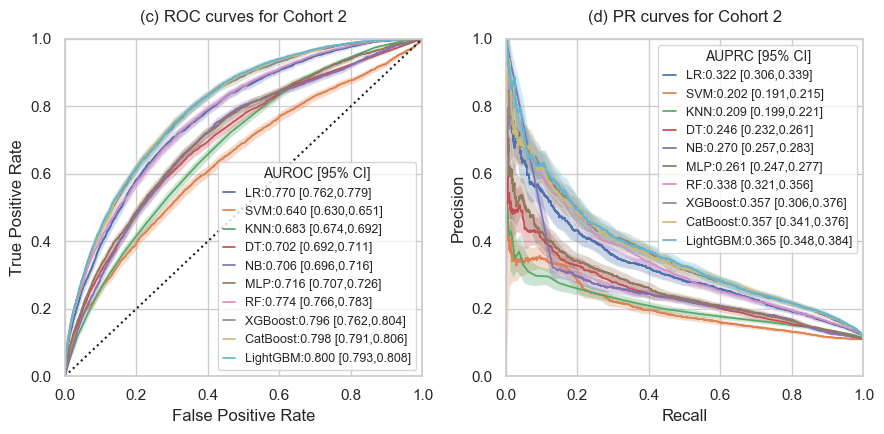

In [73]:
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

################################### plot figures roc_pc_calibration curves ###########################
models = ['LR','SVM','KNN','DTC','NB','MLP','RF','XGBoost','Catboost','LightGBM']
#colors =['#2ca02c','#d62728','#1f77b4','#ff7f0e']


allData = {}
for model in models:
    temp = pickle.load(open(save_path+'/results/roc_pr_cali_CI_Model_'+model+'.pkl','rb'))
    allData[model] = temp


def draw_roc_pr_cali_curves():
    fig = plt.figure(figsize=(9,4.5))
    ##=================for roc curve========================
    ax1 = plt.subplot(1,2,1) 
    ## for model_i
    for model in models:
        temp = allData[model]
        data = temp['roc_CI']
        fpr = data['roc_curve'][0];tpr = data['roc_curve'][1];
        mean_fpr = data['mean_fpr']; tprs_lower=data['tprs_lower']; tprs_upper=data['tprs_upper']
        plt.plot(fpr,tpr,lw=1.25, label=model)#, color=colors[s]
        plt.fill_between(mean_fpr,tprs_lower,tprs_upper, alpha=0.3, label="_nolegend_")#, color=colors[s]
     
    lg = plt.legend(
        [   
            'LR:{:.3f} [{:.3f},{:.3f}]'.format(allData['LR']['roc_CI']['auc'],allData['LR']['roc_CI']['dci'],allData['LR']['roc_CI']['uci']),
            'SVM:{:.3f} [{:.3f},{:.3f}]'.format(allData['SVM']['roc_CI']['auc'],allData['SVM']['roc_CI']['dci'],allData['SVM']['roc_CI']['uci']),            
            'KNN:{:.3f} [{:.3f},{:.3f}]'.format(allData['KNN']['roc_CI']['auc'],allData['KNN']['roc_CI']['dci'],allData['KNN']['roc_CI']['uci']),
            'DT:{:.3f} [{:.3f},{:.3f}]'.format(allData['DTC']['roc_CI']['auc'],allData['DTC']['roc_CI']['dci'],allData['DTC']['roc_CI']['uci']),            
            'NB:{:.3f} [{:.3f},{:.3f}]'.format(allData['NB']['roc_CI']['auc'],allData['NB']['roc_CI']['dci'],allData['NB']['roc_CI']['uci']),
            'MLP:{:.3f} [{:.3f},{:.3f}]'.format(allData['MLP']['roc_CI']['auc'],allData['MLP']['roc_CI']['dci'],allData['MLP']['roc_CI']['uci']),
            'RF:{:.3f} [{:.3f},{:.3f}]'.format(allData['RF']['roc_CI']['auc'],allData['RF']['roc_CI']['dci'],allData['RF']['roc_CI']['uci']),
            'XGBoost:{:.3f} [{:.3f},{:.3f}]'.format(allData['XGBoost']['roc_CI']['auc'],allData['LR']['roc_CI']['dci'],allData['XGBoost']['roc_CI']['uci']),
            'CatBoost:{:.3f} [{:.3f},{:.3f}]'.format(allData['Catboost']['roc_CI']['auc'],allData['Catboost']['roc_CI']['dci'],allData['Catboost']['roc_CI']['uci']),
            'LightGBM:{:.3f} [{:.3f},{:.3f}]'.format(allData['LightGBM']['roc_CI']['auc'],allData['LightGBM']['roc_CI']['dci'],allData['LightGBM']['roc_CI']['uci']),
            #'BFSM  : {:.3f}'.format(allData['step'+str(0)]['roc_CI']['auc']),
            #'AFSM-1: {:.3f}'.format(allData['step'+str(1)]['roc_CI']['auc']),
            #'AFSM-2: {:.3f}'.format(allData['step'+str(2)]['roc_CI']['auc']),
            #'AFSM-3: {:.3f}'.format(allData['step'+str(3)]['roc_CI']['auc']),
        ],
        title = 'AUROC [95% CI]',
        loc = 'lower right',
        handlelength = 1.0,
        fontsize = 9,
    )
    lg.get_title().set_fontsize(10)
    
    plt.plot([0,1],[0,1],'k:')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title('(c) ROC curves for Cohort 2', fontsize=12, pad=12)

    ##=================for pr curve========================
    ax2 = plt.subplot(1,2,2)     
   ## for model_i
    for model in models:
        temp = allData[model]
        data = temp['pr_CI']
        precision = data['pr_curve'][0]; recall = data['pr_curve'][1]
        mean_rec = data['mean_rec']; prec_lower=data['prec_lower']; prec_upper=data['prec_upper']
        plt.plot(recall,precision,lw=1.25, label=model)#, color=colors[s]
        plt.fill_between(mean_rec,prec_lower,prec_upper, alpha=0.3, label="_nolegend_")#, color=colors[s]
     
    lg = plt.legend(
        [
            #'BFSM   : {:.3f}'.format(allData['step'+str(0)]['pr_CI']['pr_auc']),
            #'AFSM-1: {:.3f}'.format(allData['step'+str(1)]['pr_CI']['pr_auc']),
            #'AFSM-2: {:.3f}'.format(allData['step'+str(2)]['pr_CI']['pr_auc']),
            #'AFSM-3: {:.3f}'.format(allData['step'+str(3)]['pr_CI']['pr_auc']),
            #models = ['LR','SVM','KNN','DTC','NB','MLP','RF','XGBoost','Catboost','LightGBM']
            'LR:{:.3f} [{:.3f},{:.3f}]'.format(allData['LR']['pr_CI']['pr_auc'],allData['LR']['pr_CI']['pr_dci'],allData['LR']['pr_CI']['pr_uci']),
            'SVM:{:.3f} [{:.3f},{:.3f}]'.format(allData['SVM']['pr_CI']['pr_auc'],allData['SVM']['pr_CI']['pr_dci'],allData['SVM']['pr_CI']['pr_uci']),            
            'KNN:{:.3f} [{:.3f},{:.3f}]'.format(allData['KNN']['pr_CI']['pr_auc'],allData['KNN']['pr_CI']['pr_dci'],allData['KNN']['pr_CI']['pr_uci']),
            'DT:{:.3f} [{:.3f},{:.3f}]'.format(allData['DTC']['pr_CI']['pr_auc'],allData['DTC']['pr_CI']['pr_dci'],allData['DTC']['pr_CI']['pr_uci']),            
            'NB:{:.3f} [{:.3f},{:.3f}]'.format(allData['NB']['pr_CI']['pr_auc'],allData['NB']['pr_CI']['pr_dci'],allData['NB']['pr_CI']['pr_uci']),
            'MLP:{:.3f} [{:.3f},{:.3f}]'.format(allData['MLP']['pr_CI']['pr_auc'],allData['MLP']['pr_CI']['pr_dci'],allData['MLP']['pr_CI']['pr_uci']),
            'RF:{:.3f} [{:.3f},{:.3f}]'.format(allData['RF']['pr_CI']['pr_auc'],allData['RF']['pr_CI']['pr_dci'],allData['RF']['pr_CI']['pr_uci']),
            'XGBoost:{:.3f} [{:.3f},{:.3f}]'.format(allData['XGBoost']['pr_CI']['pr_auc'],allData['LR']['pr_CI']['pr_dci'],allData['XGBoost']['pr_CI']['pr_uci']),
            'CatBoost:{:.3f} [{:.3f},{:.3f}]'.format(allData['Catboost']['pr_CI']['pr_auc'],allData['Catboost']['pr_CI']['pr_dci'],allData['Catboost']['pr_CI']['pr_uci']),
            'LightGBM:{:.3f} [{:.3f},{:.3f}]'.format(allData['LightGBM']['pr_CI']['pr_auc'],allData['LightGBM']['pr_CI']['pr_dci'],allData['LightGBM']['pr_CI']['pr_uci']),  
        ],
        title = 'AUPRC [95% CI]',
        loc = 'upper right',#'lower left',
        handlelength = 1.0,
        fontsize = 9,
    )
    lg.get_title().set_fontsize(10)    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim(0,1)
    plt.ylim(0,1)
    #plt.title('{}.T={}.dt={}'.format(tast,T,dt))    
    plt.title('(d) PR curves for Cohort 2', fontsize=12, pad=12)
    
    #########################################################        
    plt.tight_layout()
    plt.savefig(save_path+'/figure/figure_roc_pr_curves_MIMIC.png',dpi=300)
    #plt.savefig(save_path+'/figure/figure_roc_pr_cali_curves.eps',format='eps',dpi=300)
    #plt.show()
         
    
        
draw_roc_pr_cali_curves()    
    
